## License

This notebook is a conversion of a Sentinel Hub evalscript and is licensed under
**CC-BY-SA-4.0**.

Original evalscript: https://custom-scripts.sentinel-hub.com/sentinel-2/bais2/  
Source: Sentinel Hub Custom Scripts (CC-BY-SA-4.0)  
Conversion: Development Seed (openEO-UDP project)  

# Braaten-Cohen-Yang Cloud Detector and OpenEO

This notebook demonstrates how to detect thick and thin clouds using SWIR and green bands. The Braaten-Cohen-Young algorithm defines a subspace in Sentinel-2 spectral space that captures most cloud pixels using simple threshold tests on the green band and NDGR. To reduce snow misclassification, an additional SWIR constraint is applied.

$B_{11} > \tau \land \bigl( (B_{03} > 0{.}175 \land \mathrm{NDGR} > 0) \lor B_{03} > 0{.}39 \bigr)$

Where
$\mathrm{NDGR} = \frac{B03 - B04}{B03 + B04}$

And
- B03 (559.8 nm): Green band
- B04 (664.6 nm): Red band
- $\tau$ = 0.1

Meaning that:
- Condition A which detects normal clouds while avoiding vegetation: the pixel is moderately bright in green (`B03 > 0.175`) AND green reflectance is higher than red (`NDGR > 0` which is signified when `B03 > B04`)
- OR Condition B which detects thick clouds: the pixel is bright in green (`B03 > 0.39`)
- The threshold for $\tau$ was chosen arbitrarily, a more educated guess may give better results. 

## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization

In [ ]:
import openeo
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
from openeo.processes import array_create, if_, and_, sqrt, clip

## Connect to OpenEO Backend

Connect to the OpenEO backend and authenticate using OpenID Connect.

In [ ]:
connection = openeo.connect(
    url="https://openeo.dataspace.copernicus.eu/"
).authenticate_oidc()

## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates for Orbetello, Italy.

In [ ]:
spatial_extent = {"west" : 10.888880981544304, "south" : 42.33121019418769, "east" : 11.64964461765868, "north" : 42.621046146854724}

## Load Sentinel-2 Data

Load Sentinel-2 L2A (bottom-of-atmosphere reflectance) data. We need multiple bands for cloud detection:
- **B02** (Blue, 492.4 nm)
- **B03** (Green, 559.8 nm) 
- **B04** (Red, 664.6 nm)
- **B11** (SWIR, 1613.7 nm)

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=["2017-10-06", "2017-10-06"], # 
    bands=[
        "B02",
        "B03",
        "B04",
        "B11",
        "SCL"
    ],
)

s2cube = s2cube.reduce_dimension(dimension="t", reducer="first")

In [ ]:
def cloud_detection(data):
    # Evalscript reference: index(x,y)=(x-y)/(x+y); NDGR=index(B03,B04); same logic as reference
    B02, B03, B04, B11 = (data[0], data[1], data[2], data[3])

    # Scale CDSE integer data to reflectance [0, 1]
    B02 = B02 / 10000
    B03 = B03 / 10000
    B04 = B04 / 10000
    B11 = B11 / 10000

    bRatio = (B03 - 0.175) / (0.39 - 0.175)
    NDGR = (B03 - B04) / (B03 + B04)
    gain = 2.5

    v_thick = 0.5 * (bRatio - 1)
    v_thin = 5 * sqrt(bRatio * NDGR)

    thick = and_(B11 > 0.1, bRatio > 1)
    thin = and_(B11 > 0.1, and_(bRatio > 0, NDGR > 0))

    red = if_(
        thick,
        0.5 * clip(B04, 0, 1),
        if_(
            thin, 
            0.5 * clip(B04, 0, 1) + v_thin, 
            gain * B04
        ),
    )
    green = if_(
        thick, 
        0.5 * clip(B03, 0, 1), 
        if_(
            thin, 
            0.5 * clip(B03, 0, 1), 
            gain * B03
        )
    )
    blue = if_(
        thick,
        0.5 * clip(B02, 0, 1) + v_thick,
        if_(
            thin, 
            0.5 * clip(B02, 0, 1), 
            gain * B02),
    )

    red = clip(red, 0, 1)
    green = clip(green, 0, 1)
    blue = clip(blue, 0, 1)

    result = array_create([
        red, green, blue
    ])
    
    return result

In [ ]:
cohen_braaten_yang_cloud_detection = s2cube.apply_dimension(
    dimension="bands",
    process=cloud_detection
)

# cby_cloud_detection_image = cby_cloud_detection_image.save_result("PNG")

cby_cloud_detection_image = (
      cohen_braaten_yang_cloud_detection
      .save_result("GTIFF")
  )

cby_cloud_detection_image.download("cby_cloud_detection_image.tif")

## Visualize the Result

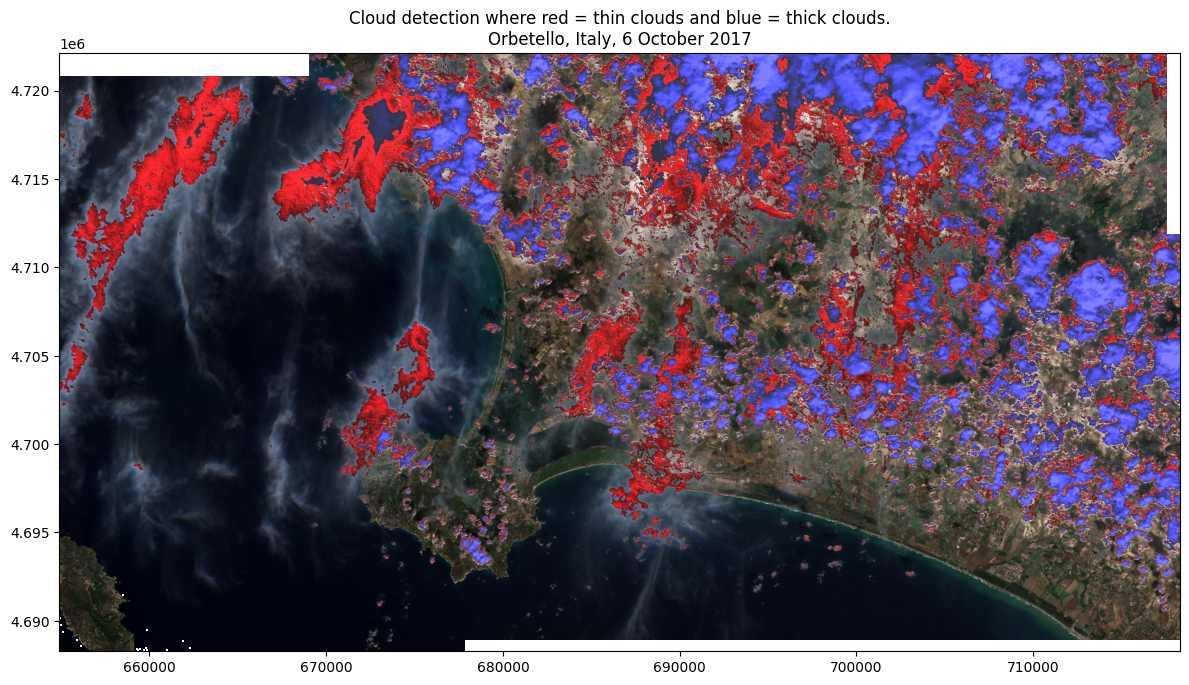

In [9]:
ds = rioxarray.open_rasterio("cby_cloud_detection_image.tif")

rgb = np.stack([
    ds.sel(band=1).values,
    ds.sel(band=2).values,
    ds.sel(band=3).values
], axis=-1)

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb, extent=[ds.x.values.min(), ds.x.values.max(), ds.y.values.min(), ds.y.values.max()])
ax.set_aspect("equal")
plt.title(
    "Cloud detection where red = thin clouds and blue = thick clouds.\n"
    "Orbetello, Italy, 6 October 2017"
)
plt.tight_layout()
plt.show()

## Interpretation Guide

### Cloud-detection visualization

| Color   | SWIR band (B11) | Normalized green (bRatio) | Cloud type  |
|---------|-----------------|---------------------------|-------------|
| Blue    | High SWIR       | High green (bRatio > 1)   | Thick cloud |
| Red     | High SWIR       | Moderate green (0 < bRatio ≤ 1) and NDGR > 0 | Thin cloud |
| Natural | Low SWIR        | —                         | Clear       |

- **Thick cloud:** high SWIR and high green (B03 > 0.39, i.e. bRatio > 1); rendered with a blue tint.
- **Thin cloud:** high SWIR and moderate green with NDGR > 0 (B03 > 0.175 and B03 > B04); rendered with a red tint.
- **Clear:** low SWIR or failing the cloud conditions; rendered with natural RGB (gain × bands).

Without SWIR, Braaten-Cohen-Young detector achieves 73% accuracy on a control dataset, with most errors due to snow misclassification and missed thin clouds. Including SWIR improves accuracy to 88%, with remaining errors primarily due to cirrus clouds.

**Notes on the $\tau$ thresholds**
- Thresholds used in the algorithm is 0.1 while the authors mention they're using %\tau$ = 0.2

### Applications:
- A simple algorithm to detect thick, translucent, and transparent clouds while reducing snow misclassification
- Can be used to mask clouds for further environmental data analysis

### Limitations
- Can't identify cirrus clouds which can create bias in indices calculation

## Citation
Braaten, J., Cohen, WB., Yang, Z. (2015). Automated cloud and cloud shadow identification in Landsat MSS imagery for temperate ecosystems. *Remote Sensing of Environment*, 169:128-138. https://doi.org/10.1016/j.rse.2015.08.006

## Attribution

This openEO User-Defined Process is a conversion of the original Sentinel Hub evalscript:

**Original Script:** [Braaten-Cohen-Yang Cloud Detector)](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cby_cloud_detection/)

**Source Repository:** [Sentinel Hub Custom Scripts](https://github.com/sentinel-hub/custom-scripts)

This conversion maintains the scientific methodology and visualization approach of the original evalscript while adapting it to the openEO process graph framework for interoperability across openEO-compliant backends.